In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.models import Model
from keras.layers import Input, Dense
from keras import regularizers
import matplotlib.pyplot as plt
from scipy.stats import f

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


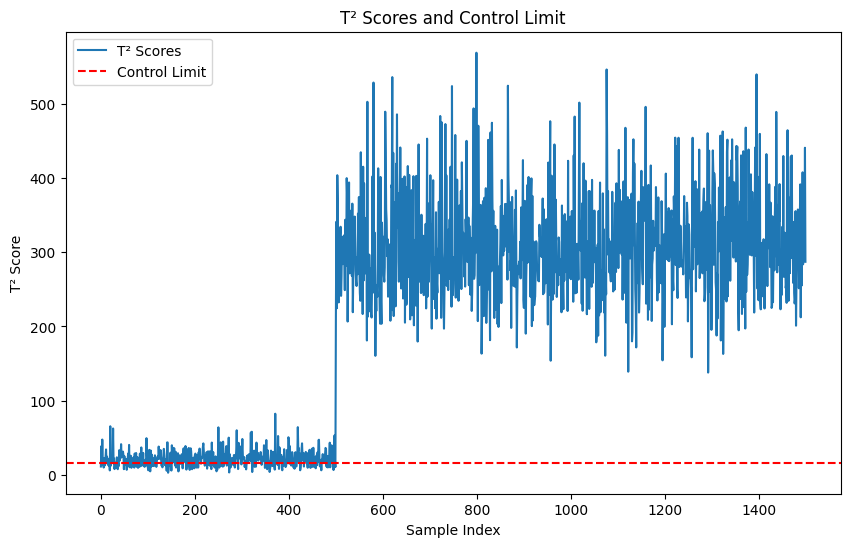

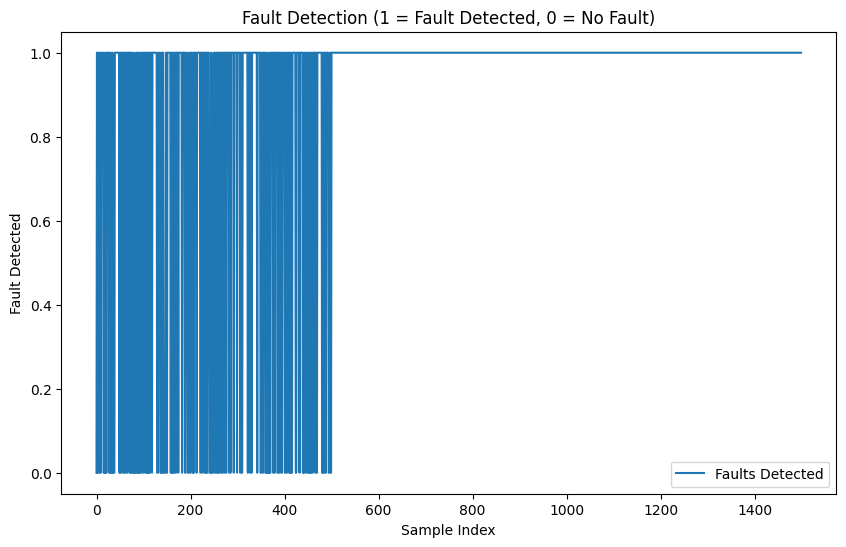

Faults detected: 1332 out of 0 faulty samples.


In [ ]:

def normalize_data(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_normalized = (X - mean) / std
    return X_normalized, mean, std

def calculate_t2_score(X, mean, std, encoder, cov_matrix):
    X_normalized = (X - mean) / std

    encoded_data = encoder.predict(X_normalized)

    # Compute T² statistics
    Qy = np.linalg.pinv(cov_matrix)
    t2_scores = np.array([np.dot(np.dot(encoded_data[i], Qy), encoded_data[i].T) for i in range(len(encoded_data))])

    return t2_scores

np.random.seed(42)


Nw = 500  # Number of initial fault-free samples
N = 1500  # Total samples
n_features = 10 # Total features

X_normal = np.random.normal(0, 1, (Nw, n_features))
X_faulty = np.random.normal(5, 1, (N - Nw, n_features))  # Faulty samples
X = np.vstack([X_normal, X_faulty])

# Add noise
St_D = 0.01
X += St_D * np.random.randn(*X.shape)

# Normalize the data
X_normalized, mean, std = normalize_data(X[:Nw])

# Define autoencoder with two hidden layers
input_layer = Input(shape=(n_features,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)

decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(n_features, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

# Compile and train autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_normalized, X_normalized, epochs=50, batch_size=32, shuffle=True, verbose=0)

encoded_train = encoder.predict(X_normalized)
cov_matrix = np.cov(encoded_train, rowvar=False)

# Adding regularization to covariance matrix to avoid singularity
epsilon = 1e-6
cov_matrix += np.eye(cov_matrix.shape[0]) * epsilon

# Calculate T² scores for the entire dataset
t2_scores = calculate_t2_score(X, mean, std, encoder, cov_matrix)

p = encoded_train.shape[1]  # Number of dimensions in the encoded space
alpha = 0.05
F_critical = f.ppf(1 - alpha, p, Nw - p)
control_limit = (p * (Nw - 1) * (Nw + 1)) / (Nw * (Nw - p)) * F_critical

# Detect faults
faults_detected = t2_scores > control_limit

# Plot T² scores and control limit
plt.figure(figsize=(10, 6))
plt.plot(t2_scores, label="T² Scores")
plt.axhline(y=control_limit, color='r', linestyle='--', label="Control Limit")
plt.title("T² Scores and Control Limit")
plt.xlabel("Sample Index")
plt.ylabel("T² Score")
plt.legend()
plt.show()

# Plot detected faults
plt.figure(figsize=(10, 6))
plt.plot(faults_detected, label="Faults Detected")
plt.title("Fault Detection (1 = Fault Detected, 0 = No Fault)")
plt.xlabel("Sample Index")
plt.ylabel("Fault Detected")
plt.legend()
plt.show()
print(f"Faults detected: {np.sum(faults_detected)} out of {len(faults_detected) - 1500} faulty samples.")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


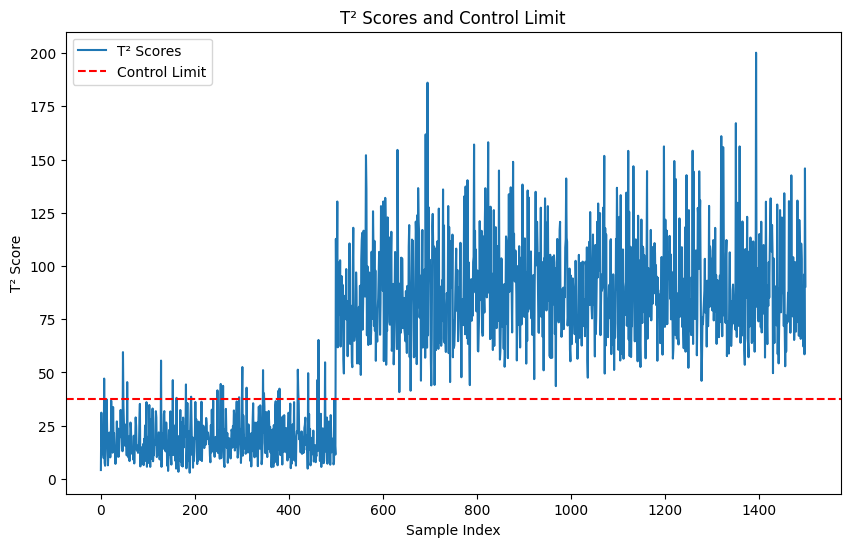

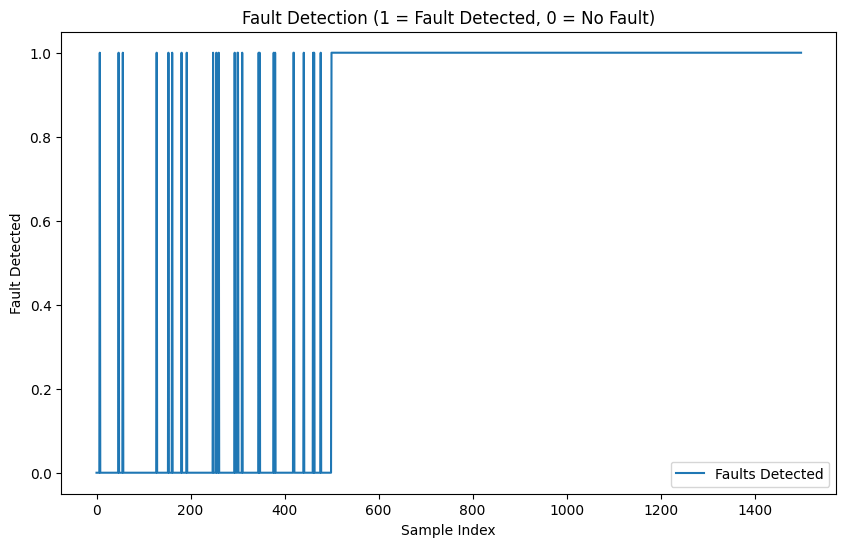

Faults detected: 1025 out of 0 faulty samples.


In [ ]:

def normalize_data(X):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    X_normalized = (X - mean) / std
    return X_normalized, mean, std

def calculate_t2_score(X, mean, std, encoder, cov_matrix):

    X_normalized = (X - mean) / std

    encoded_data = encoder.predict(X_normalized)

    # Compute T² statistics
    Qy = np.linalg.pinv(cov_matrix)
    t2_scores = np.array([np.dot(np.dot(encoded_data[i], Qy), encoded_data[i].T) for i in range(len(encoded_data))])

    return t2_scores


np.random.seed(42)


Nw = 500  # Number of initial fault-free samples
N = 1500  # Total samples
n_features = 10 # Total Number of features


X_normal = np.random.normal(0, 1, (Nw, n_features))
X_faulty = np.random.normal(6, 1, (N - Nw, n_features))  # Faulty samples
X = np.vstack([X_normal, X_faulty])

# Adding noise
St_D = 0.01
X += St_D * np.random.randn(*X.shape)

# Normalize the data
X_normalized, mean, std = normalize_data(X[:Nw])

# Define autoencoder with two hidden layers
input_layer = Input(shape=(n_features,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)

decoded = Dense(16, activation='relu')(encoded)
decoded = Dense(n_features, activation='sigmoid')(decoded)

autoencoder = Model(input_layer, decoded)
encoder = Model(input_layer, encoded)

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_normalized, X_normalized, epochs=50, batch_size=32, shuffle=True, verbose=0)


encoded_train = encoder.predict(X_normalized)
cov_matrix = np.cov(encoded_train, rowvar=False)

epsilon = 1e-6
cov_matrix += np.eye(cov_matrix.shape[0]) * epsilon

# Calculate T² scores for the entire dataset
t2_scores = calculate_t2_score(X, mean, std, encoder, cov_matrix)

#Setting control limit
control_limit = np.percentile(t2_scores[:Nw], 95)

# Detecting  faults
faults_detected = t2_scores > control_limit

# Plot T² scores and control limit
plt.figure(figsize=(10, 6))
plt.plot(t2_scores, label="T² Scores")
plt.axhline(y=control_limit, color='r', linestyle='--', label="Control Limit")
plt.title("T² Scores and Control Limit")
plt.xlabel("Sample Index")
plt.ylabel("T² Score")
plt.legend()
plt.show()

# Plot detected faults
plt.figure(figsize=(10, 6))
plt.plot(faults_detected, label="Faults Detected")
plt.title("Fault Detection (1 = Fault Detected, 0 = No Fault)")
plt.xlabel("Sample Index")
plt.ylabel("Fault Detected")
plt.legend()
plt.show()
print(f"Faults detected: {np.sum(faults_detected)} out of {len(faults_detected) - 1500} faulty samples.")